# Stacked Bidirectional LSTM Sentiment Classifier

In this notebook, we *stack* LSTM layers to classify IMDB movie reviews by their sentiment.

#### Load dependencies

In [1]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import Bidirectional 
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 

#### Set hyperparameters

In [2]:
# output directory name:
output_dir = 'model_output/stackedLSTM'

# training:
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 64 
n_unique_words = 10000 
max_review_length = 200 
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# LSTM layer architecture:
# we are using two LSTM layers.
n_lstm_1 = 64 # lower
n_lstm_2 = 64 # new!
drop_lstm = 0.2

#### Load data

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

#### Preprocess data

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design neural network architecture

In [5]:
model = Sequential()

# Input layer - embeddings.
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))

# First Hidden layer - Bidirectional LSTM - since we have additional RNN layer after this (bidirectional LSTM)
# we have to enable return_sequences - true for the current RNN layer.
# It will pass all input sequence for each step to next RNN layer.
model.add(Bidirectional(LSTM(n_lstm_1, dropout=drop_lstm, 
                             return_sequences=True))) 

# Second hidden layer - bidirectional LSTM
model.add(Bidirectional(LSTM(n_lstm_2, dropout=drop_lstm)))

# output layer:
model.add(Dense(1, activation='sigmoid'))

/Users/sshivagangeprakash/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


#### Configure model

In [6]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [7]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.keras")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [8]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 112s 560ms/step - accuracy: 0.6853 - loss: 0.5645 - val_accuracy: 0.8687 - val_loss: 0.3371
Epoch 2/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 126s 641ms/step - accuracy: 0.9019 - loss: 0.2514 - val_accuracy: 0.8748 - val_loss: 0.2989
Epoch 3/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 129s 657ms/step - accuracy: 0.9333 - loss: 0.1797 - val_accuracy: 0.8674 - val_loss: 0.3216
Epoch 4/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 124s 634ms/step - accuracy: 0.9518 - loss: 0.1392 - val_accuracy: 0.8691 - val_loss: 0.3345


In [9]:
# LSTM layer parameters double due to both reading directions
model.summary() 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 200, 64)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,414,982 (9.21 MB)

 Trainable params: 804,993 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,609,989 (6.14 MB)

#### Evaluate

In [10]:
model.load_weights(output_dir+"/weights.02.keras") 

In [11]:
y_hat = model.predict(x_valid)

782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step


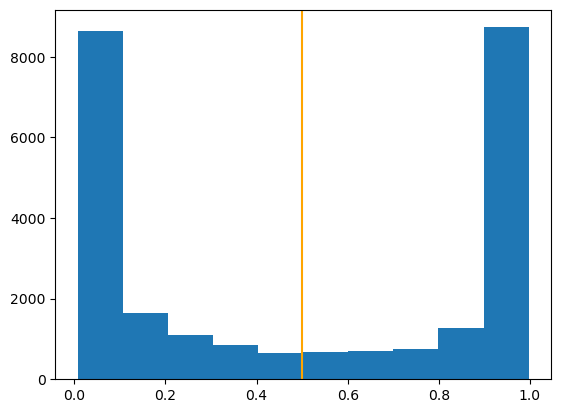

In [12]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [13]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'94.78'